In [1]:
### Import Packages

In [224]:
import os
from copy import deepcopy as dc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [ ]:
## Univariat

In [3]:
active_losses = pd.read_csv('../data/Avtice-losses.csv', skiprows=1)
active_losses.head(3)

,Zeitstempel,kWh
0,2019-01-01 00:15:00,39143.346123
1,2019-01-01 00:30:00,32788.068958
2,2019-01-01 00:45:00,33018.915678


In [4]:
active_losses['Zeitstempel'] = pd.to_datetime(active_losses['Zeitstempel']) - pd.Timedelta(minutes=15)
active_losses.head(3)

,Zeitstempel,kWh
0,2019-01-01 00:00:00,39143.346123
1,2019-01-01 00:15:00,32788.068958
2,2019-01-01 00:30:00,33018.915678


In [5]:
active_losses.set_index('Zeitstempel', inplace=True)
active_losses.head(3)

,kWh
Zeitstempel,
2019-01-01 00:00:00,39143.346123
2019-01-01 00:15:00,32788.068958
2019-01-01 00:30:00,33018.915678


In [6]:
active_losses["MWh"] = active_losses["kWh"]/1000
active_losses.head(3)

,kWh,MWh
Zeitstempel,,
2019-01-01 00:00:00,39143.346123,39.143346
2019-01-01 00:15:00,32788.068958,32.788069
2019-01-01 00:30:00,33018.915678,33.018916


In [7]:
active_losses = active_losses[~active_losses.index.duplicated(keep='first')]
active_losses.head(3)

,kWh,MWh
Zeitstempel,,
2019-01-01 00:00:00,39143.346123,39.143346
2019-01-01 00:15:00,32788.068958,32.788069
2019-01-01 00:30:00,33018.915678,33.018916


In [8]:
active_losses = active_losses.interpolate(method='linear')
active_losses.head(3)

,kWh,MWh
Zeitstempel,,
2019-01-01 00:00:00,39143.346123,39.143346
2019-01-01 00:15:00,32788.068958,32.788069
2019-01-01 00:30:00,33018.915678,33.018916


In [9]:
active_losses_agg = active_losses.resample('60T').sum()
active_losses_agg.head(3)

,kWh,MWh
Zeitstempel,,
2019-01-01 00:00:00,139525.003695,139.525004
2019-01-01 01:00:00,129716.036003,129.716036
2019-01-01 02:00:00,133398.074458,133.398074


<Axes: xlabel='Zeitstempel'>

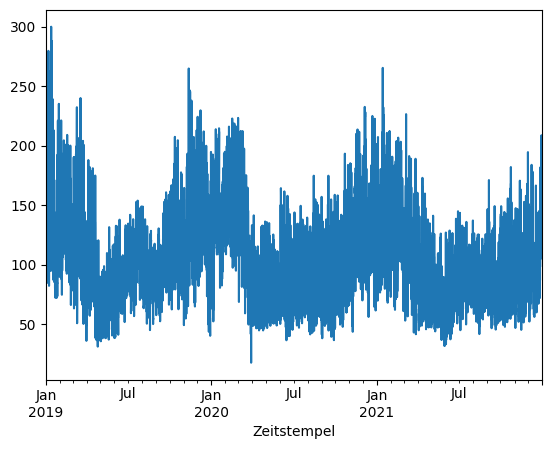

In [10]:
df_agg = active_losses_agg["MWh"]
df_agg.plot()

In [11]:
from copy import deepcopy as dc

In [12]:
df_agg = pd.DataFrame(df_agg)

In [13]:
def prepare_dataframe_for_multistep_lstm(df, n_steps, forecast_horizon=24):
    df_list = []
    for i in range(len(df) - n_steps - forecast_horizon + 1):
        # Eingabedaten
        input_data = df["MWh"].iloc[i : i + n_steps].tolist()
        # Zielwerte
        output_data = df["MWh"].iloc[i + n_steps : i + n_steps + forecast_horizon].tolist()
        df_list.append(input_data + output_data)

    # Spaltennamen erstellen
    columns = [f'input(t-{n_steps - j})' for j in range(n_steps)] + [f'target(t+{i})' for i in range(forecast_horizon)]
    return pd.DataFrame(df_list, columns=columns)

lookback = 168
forecast_horizon = 24
prepared_df = prepare_dataframe_for_multistep_lstm(df_agg, lookback, forecast_horizon)

In [14]:
prepared_df

,input(t-168),input(t-167),input(t-166),input(t-165),input(t-164),input(t-163),input(t-162),input(t-161),input(t-160),input(t-159),...,target(t+14),target(t+15),target(t+16),target(t+17),target(t+18),target(t+19),target(t+20),target(t+21),target(t+22),target(t+23)
0,139.525004,129.716036,133.398074,135.133852,131.699424,147.391128,167.629536,189.136693,197.988811,193.205145,...,141.994337,144.479872,136.093315,118.696534,129.779820,125.225515,134.814779,149.877976,164.010922,171.343323
1,129.716036,133.398074,135.133852,131.699424,147.391128,167.629536,189.136693,197.988811,193.205145,188.108696,...,144.479872,136.093315,118.696534,129.779820,125.225515,134.814779,149.877976,164.010922,171.343323,173.184594
2,133.398074,135.133852,131.699424,147.391128,167.629536,189.136693,197.988811,193.205145,188.108696,177.246809,...,136.093315,118.696534,129.779820,125.225515,134.814779,149.877976,164.010922,171.343323,173.184594,172.738969
3,135.133852,131.699424,147.391128,167.629536,189.136693,197.988811,193.205145,188.108696,177.246809,147.491664,...,118.696534,129.779820,125.225515,134.814779,149.877976,164.010922,171.343323,173.184594,172.738969,192.147994
4,131.699424,147.391128,167.629536,189.136693,197.988811,193.205145,188.108696,177.246809,147.491664,146.295818,...,129.779820,125.225515,134.814779,149.877976,164.010922,171.343323,173.184594,172.738969,192.147994,188.856706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26108,71.702086,79.204443,68.907638,67.107170,98.765158,96.965601,104.161457,125.646293,119.037914,118.070052,...,149.349078,150.967027,152.648212,145.792085,167.343565,176.617953,188.541866,162.995636,152.159763,171.707318
26109,79.204443,68.907638,67.107170,98.765158,96.965601,104.161457,125.646293,119.037914,118.070052,106.971474,...,150.967027,152.648212,145.792085,167.343565,176.617953,188.541866,162.995636,152.159763,171.707318,159.462903
26110,68.907638,67.107170,98.765158,96.965601,104.161457,125.646293,119.037914,118.070052,106.971474,106.122274,...,152.648212,145.792085,167.343565,176.617953,188.541866,162.995636,152.159763,171.707318,159.462903,155.109520
26111,67.107170,98.765158,96.965601,104.161457,125.646293,119.037914,118.070052,106.971474,106.122274,98.921506,...,145.792085,167.343565,176.617953,188.541866,162.995636,152.159763,171.707318,159.462903,155.109520,171.370277


In [15]:
prepared_df_as_np = prepared_df.to_numpy()

In [16]:
prepared_df_as_np

array([[139.5250037 , 129.716036  , 133.39807446, ..., 149.87797571,
        164.01092216, 171.34332328],
       [129.716036  , 133.39807446, 135.13385173, ..., 164.01092216,
        171.34332328, 173.18459407],
       [133.39807446, 135.13385173, 131.69942406, ..., 171.34332328,
        173.18459407, 172.73896946],
       ...,
       [ 68.90763803,  67.10716988,  98.7651584 , ..., 171.70731761,
        159.46290341, 155.10951973],
       [ 67.10716988,  98.7651584 ,  96.96560137, ..., 159.46290341,
        155.10951973, 171.37027694],
       [ 98.7651584 ,  96.96560137, 104.16145706, ..., 155.10951973,
        171.37027694, 146.05479082]])

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
prepared_df_as_np = scaler.fit_transform(prepared_df_as_np)

prepared_df_as_np

array([[-0.13609887, -0.20554245, -0.17947508, ..., -0.06280397,
         0.03725165,  0.08916212],
       [-0.20554245, -0.17947508, -0.16718647, ...,  0.03725165,
         0.08916212,  0.10219758],
       [-0.17947508, -0.16718647, -0.19150085, ...,  0.08916212,
         0.10219758,  0.09904274],
       ...,
       [-0.63604161, -0.64878821, -0.4246623 , ...,  0.09173905,
         0.00505349, -0.02576672],
       [-0.64878821, -0.4246623 , -0.43740244, ...,  0.00505349,
        -0.02576672,  0.08935294],
       [-0.4246623 , -0.43740244, -0.38645866, ..., -0.02576672,
         0.08935294, -0.08987059]])

In [18]:
X = prepared_df_as_np[:, 0:168]
y = prepared_df_as_np[:, 168:]

In [19]:
X.shape, y.shape

((26113, 168), (26113, 24))

In [20]:
X = dc(np.flip(X, axis=1))

In [21]:
split_index = int(len(X)* 0.80)
split_index

20890

In [22]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((20890, 168), (5223, 168), (20890, 24), (5223, 24))

In [23]:
X_train = X_train.reshape((20890, 168, 1))
X_val = X_val.reshape((5223, 168, 1))

In [24]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([20890, 168, 1]),
 torch.Size([5223, 168, 1]),
 torch.Size([20890, 24]),
 torch.Size([5223, 24]))

In [25]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [26]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [27]:
#It is a common PyTorch practice to initialize a variable, usually called device, 
#that contains the device we are training on (CPU or GPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [28]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 168, 1]) torch.Size([32, 24])


In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                           batch_first=True)
        self.fc = nn.Linear(hidden_size, 24)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model_new = LSTM(1, 4, 1)
model_new.to(device)
model_new

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=24, bias=True)
)

In [30]:
def train_one_epoch():
    model_new.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model_new(x_batch)
        loss = loss_function(output, y_batch)
        running_loss = running_loss + loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, loss {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            
            running_loss = 0.0
    
    print()

In [31]:
def validate_one_epoch():
    model_new.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(val_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            
            output = model_new(x_batch)
            loss = loss_function(output, y_batch)
            running_loss = running_loss + loss
        
    avg_loss_across_batches = running_loss / len(val_loader)
    
    print("Val Loss: {0:.3f}".format(avg_loss_across_batches))
    print("***************************************************")
    print()

In [32]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model_new.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, loss 0.460
Batch 200, loss 0.288
Batch 300, loss 0.212
Batch 400, loss 0.251
Batch 500, loss 0.148
Batch 600, loss 0.203

Val Loss: 0.140
***************************************************

Epoch: 2
Batch 100, loss 0.248
Batch 200, loss 0.117
Batch 300, loss 0.214
Batch 400, loss 0.240
Batch 500, loss 0.146
Batch 600, loss 0.203

Val Loss: 0.138
***************************************************

Epoch: 3
Batch 100, loss 0.241
Batch 200, loss 0.116
Batch 300, loss 0.214
Batch 400, loss 0.233
Batch 500, loss 0.145
Batch 600, loss 0.202

Val Loss: 0.137
***************************************************

Epoch: 4
Batch 100, loss 0.236
Batch 200, loss 0.114
Batch 300, loss 0.213
Batch 400, loss 0.227
Batch 500, loss 0.144
Batch 600, loss 0.201

Val Loss: 0.137
***************************************************

Epoch: 5
Batch 100, loss 0.233
Batch 200, loss 0.114
Batch 300, loss 0.212
Batch 400, loss 0.223
Batch 500, loss 0.143
Batch 600, loss 0.200

Val Loss: 0.13

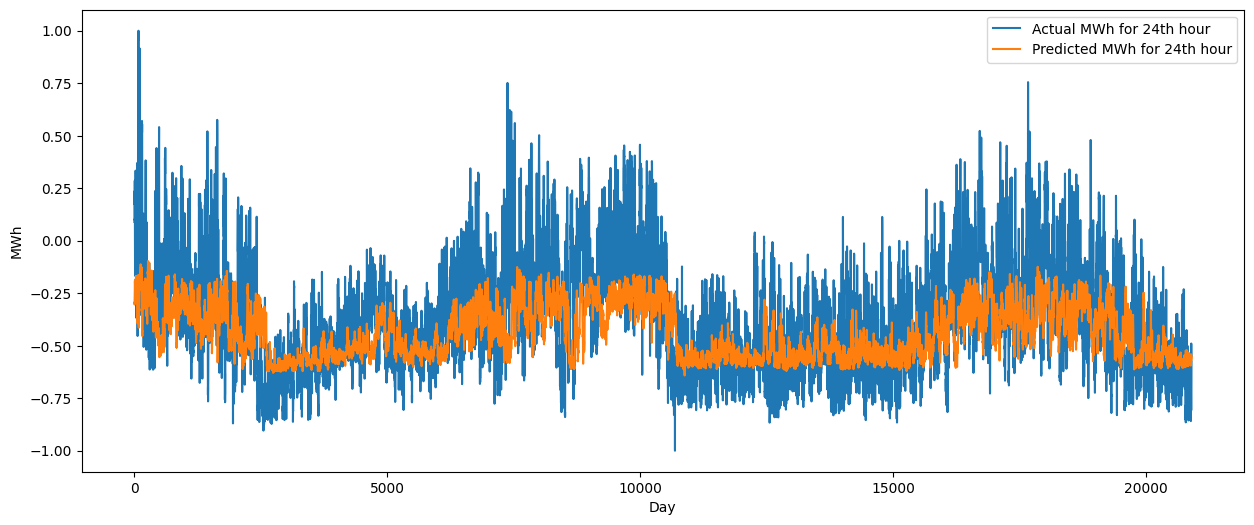

In [33]:
with torch.no_grad():
    predicted = model_new(X_train.to(device)).to("cpu").numpy()

predicted_24hr = predicted[:, -1]

plt.figure(figsize=(15, 6))
plt.plot(y_train[:, -1], label="Actual MWh for 24th hour");
plt.plot(predicted_24hr, label="Predicted MWh for 24th hour");
plt.xlabel("Day");
plt.ylabel("MWh");
plt.legend();
plt.show();

In [35]:
# Erstellen Sie einen Dummy-Array mit der gleichen Form wie Ihre ursprünglichen Daten
dummy_array = np.zeros((predicted.shape[0], 192))

# Legen Sie die Vorhersagen in die letzten 24 Spalten des Dummy-Arrays
dummy_array[:, -24:] = predicted

# Wenden Sie den Scaler auf das Dummy-Array an
destandardized_predictions = scaler.inverse_transform(dummy_array)

# Nehmen Sie nur die letzten 24 Spalten des resultierenden Arrays, das sind Ihre destandardisierten Vorhersagen
destandardized_predictions = destandardized_predictions[:, -24:]

In [36]:
# Erstellen Sie einen Dummy-Array mit der gleichen Form wie Ihre ursprünglichen Daten
dummy_array_actuals = np.zeros((y_train.shape[0], 192))

# Legen Sie die tatsächlichen Werte in die letzten 24 Spalten des Dummy-Arrays
dummy_array_actuals[:, -24:] = y_train

# Wenden Sie den Scaler auf das Dummy-Array an, um die tatsächlichen Werte zu de-standardisieren
destandardized_actuals = scaler.inverse_transform(dummy_array_actuals)

# Nehmen Sie nur die letzten 24 Spalten des resultierenden Arrays, das sind Ihre destandardisierten tatsächlichen Werte
destandardized_actuals = destandardized_actuals[:, -24:]

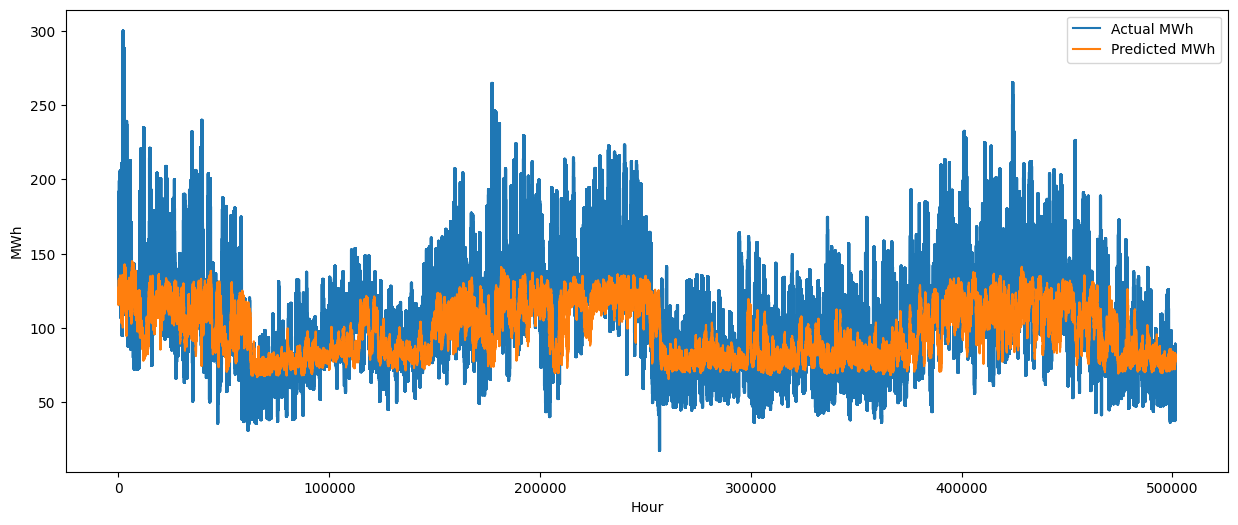

In [37]:
plt.figure(figsize=(15, 6))
plt.plot(destandardized_actuals.flatten(), label="Actual MWh")
plt.plot(destandardized_predictions.flatten(), label="Predicted MWh")
plt.xlabel("Hour")
plt.ylabel("MWh")
plt.legend()
plt.show()

In [38]:
## Validation

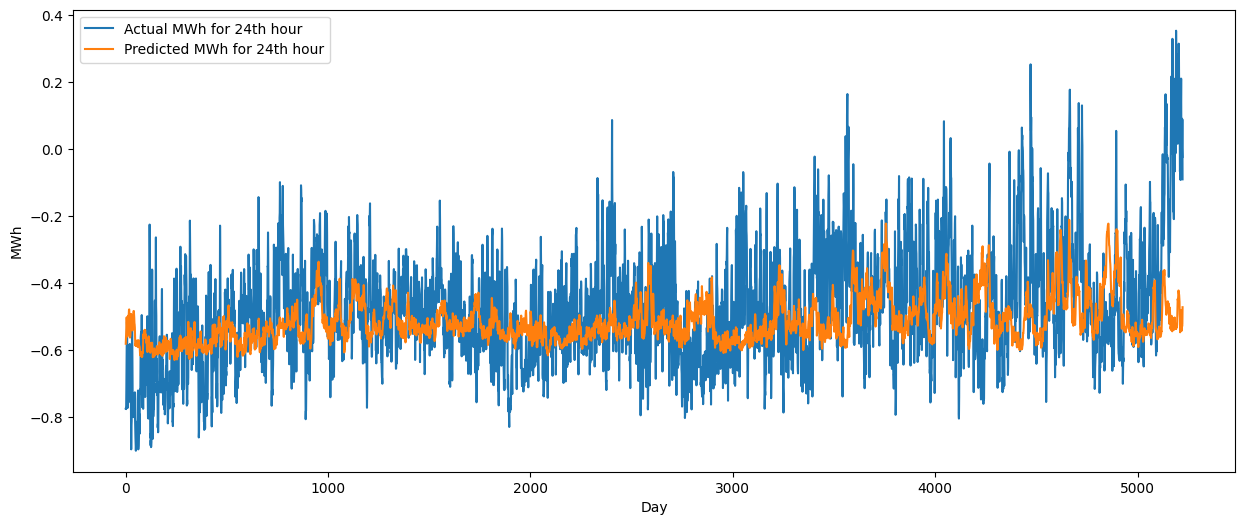

In [39]:
with torch.no_grad():
    predicted2 = model_new(X_val.to(device)).to("cpu").numpy()

predicted_24hr_2 = predicted2[:, -1]

plt.figure(figsize=(15, 6))
plt.plot(y_val[:, -1], label="Actual MWh for 24th hour");
plt.plot(predicted_24hr_2, label="Predicted MWh for 24th hour");
plt.xlabel("Day");
plt.ylabel("MWh");
plt.legend();
plt.show();

In [40]:
# Erstellen Sie einen Dummy-Array mit der gleichen Form wie Ihre ursprünglichen Daten
dummy_array2 = np.zeros((predicted2.shape[0], 192))

# Legen Sie die Vorhersagen in die letzten 24 Spalten des Dummy-Arrays
dummy_array2[:, -24:] = predicted2

# Wenden Sie den Scaler auf das Dummy-Array an
destandardized_predictions_2 = scaler.inverse_transform(dummy_array2)

# Nehmen Sie nur die letzten 24 Spalten des resultierenden Arrays, das sind Ihre destandardisierten Vorhersagen
destandardized_predictions_2 = destandardized_predictions_2[:, -24:]

In [41]:
# Erstellen Sie einen Dummy-Array mit der gleichen Form wie Ihre ursprünglichen Daten
dummy_array_actuals2 = np.zeros((y_val.shape[0], 192))

# Legen Sie die tatsächlichen Werte in die letzten 24 Spalten des Dummy-Arrays
dummy_array_actuals2[:, -24:] = y_val

# Wenden Sie den Scaler auf das Dummy-Array an, um die tatsächlichen Werte zu de-standardisieren
destandardized_actuals2 = scaler.inverse_transform(dummy_array_actuals2)

# Nehmen Sie nur die letzten 24 Spalten des resultierenden Arrays, das sind Ihre destandardisierten tatsächlichen Werte
destandardized_actuals2 = destandardized_actuals2[:, -24:]

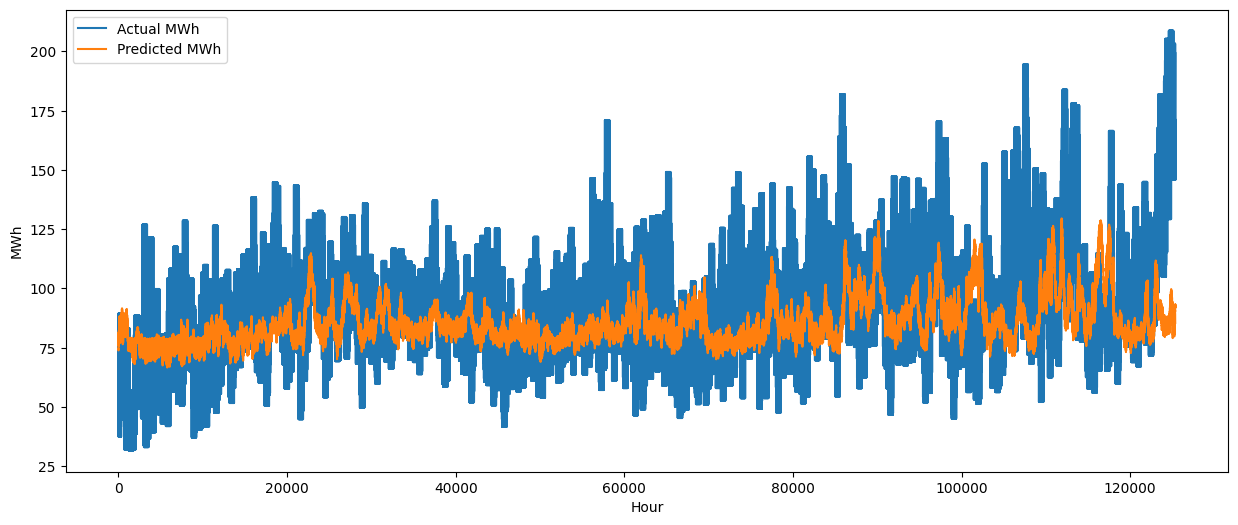

In [42]:
plt.figure(figsize=(15, 6))
plt.plot(destandardized_actuals2.flatten(), label="Actual MWh")
plt.plot(destandardized_predictions_2.flatten(), label="Predicted MWh")
plt.xlabel("Hour")
plt.ylabel("MWh")
plt.legend()
plt.show()

In [ ]:
### Multivariate

In [293]:
# Enter here location to your test data and modell
activelosses = "../data/Avtice-losses.csv"
renewablegen = "../data/Forecast-renewable-generation.csv"
forecasttemp = '../data/Forecast-temperature_new.csv'
ntc = '../data/NTC.csv'
weather = "../train_group2/Wetter.csv"
modell = "modell_group_02_v01.json"

In [294]:
# Preprocess data

In [295]:
def preprocess_and_merge_data(activelosses1, renewablegen1, forecasttemp1, ntc1, weather):
    # Load Active Losses data
    activeslosses = pd.read_csv(activelosses1, skiprows=1)
    activeslosses['Zeitstempel'] = pd.to_datetime(activeslosses['Zeitstempel']) - pd.Timedelta(minutes=15)
    activeslosses.set_index(activeslosses.columns[0], inplace=True)
    activeslosses['MWh'] = activeslosses['kWh'] / 1000
    activeslosses = activeslosses[~activeslosses.index.duplicated(keep='first')]
    activeslosses = activeslosses.resample('15T').asfreq()

    # Load Forecast Renewable Generation data
    Forecast_renew = pd.read_csv(renewablegen1, skiprows=0)
    Forecast_renew['datetime'] = pd.to_datetime(Forecast_renew['datetime'])
    Forecast_renew.set_index(Forecast_renew.columns[0], inplace=True)
    Forecast_renew = Forecast_renew[~Forecast_renew.index.duplicated(keep='first')]
    Forecast_renew = Forecast_renew.resample('H').asfreq()

    # Load Forecast Temperature data
    Forecast_temp = pd.read_csv(forecasttemp1, skiprows=0)
    Forecast_temp['datetime'] = pd.to_datetime(Forecast_temp['datetime'])
    Forecast_temp.set_index(Forecast_temp.columns[0], inplace=True)
    Forecast_temp = Forecast_temp[~Forecast_temp.index.duplicated(keep='first')]

    # Load NTC data
    NTC = pd.read_csv(ntc1, skiprows=0)
    NTC['datetime'] = pd.to_datetime(NTC['datetime'])
    NTC.set_index(NTC.columns[0], inplace=True)
    NTC = NTC[~NTC.index.duplicated(keep='first')]
    NTC = NTC.resample('H').asfreq()
    
    # Load Weather
    weather = pd.read_csv(weather, skiprows=0, delimiter=";")
    weather['datetime'] = pd.to_datetime(weather['timestamp'])
    weather.set_index(weather.columns[0], inplace=True)
    weather = weather[~weather.index.duplicated(keep='first')]
    weather.index = pd.to_datetime(weather.index)
    weather = weather.resample('H').asfreq()

    # Data preprocessing steps
    activeslosses = activeslosses.interpolate(method='polynomial', order=2)
    activeslosses_hour = activeslosses.resample('H').sum()
    Forecast_renew = Forecast_renew.interpolate(method='polynomial', order=2)
    Forecast_temp_hourly = Forecast_temp.resample('H').asfreq()
    Forecast_temp_hourly_lin = Forecast_temp_hourly.interpolate(method='linear')
    Forecast_temp_hourly_poly = Forecast_temp_hourly.interpolate(method='polynomial', order=1)
    Forecast_temp_hourly_poly.loc[pd.to_datetime('2019-01-01 00:00:00')] = Forecast_temp_hourly_poly.loc['2019-01-01 01:00:00']
    NTC = NTC.interpolate(method='polynomial', order=2)

    # Merge the dataframes
    merged_df = pd.merge(activeslosses_hour, Forecast_renew, left_index=True, right_index=True, how='outer')
    merged_df = pd.merge(merged_df, Forecast_temp_hourly_poly, left_index=True, right_index=True, how='outer')
    merged_df = pd.merge(merged_df, NTC, left_index=True, right_index=True, how='outer')
    merged_df = pd.merge(merged_df, weather, left_index=True, right_index=True, how='outer')
    
    # Save the merged dataframe to a CSV file
    #merged_df.to_csv('merged_data.csv', index=True)
    
    return merged_df.reset_index()
    
    

# Call the function to preprocess and merge the data
df = preprocess_and_merge_data(activelosses, renewablegen, forecasttemp, ntc, weather)

In [296]:
df = df.drop(columns=["kWh"])

In [297]:
df = df.drop(columns=["solar_fore_de [MW]", "solar_fore_it [MW]", "wind_fore_de [MW]", "wind_fore_it [MW]"])

In [298]:
df = df.drop(columns=["temperature_fore_fr", "temperature_fore_de", "temperature_fore_it"])

In [299]:
df = df.drop(columns=["datetime"])

In [300]:
df = df.rename(columns={"Basel Precipitation Total": "Rain", "Basel Wind Speed [10 m]": "Wind"})

In [301]:
df = df.rename(columns={"temperature_fore_ch": "Temperatur"})

In [302]:
start_time = df['index'].iloc[0]
df['Seconds'] = (df['index'] - start_time).dt.total_seconds()

In [303]:
day = 60*60*24
year = 365.2425*day

df["Day sin"] = np.sin(df["Seconds"] * (2* np.pi / day))
df["Day cos"] = np.cos(df["Seconds"] * (2* np.pi / day))
df["Year sin"] = np.sin(df["Seconds"] * (2* np.pi / year))
df["Year cos"] = np.cos(df["Seconds"] * (2* np.pi / year))

In [304]:
df

,index,MWh,Temperatur,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH,Rain,Wind,Sonne,Seconds,Day sin,Day cos,Year sin,Year cos
0,2019-01-01 00:00:00,139.525004,4.1067,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.0,0.000000,1.000000,0.000000,1.000000
1,2019-01-01 01:00:00,129.716036,4.1067,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,3600.0,0.258819,0.965926,0.000717,1.000000
2,2019-01-01 02:00:00,133.398074,3.7155,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,7200.0,0.500000,0.866025,0.001434,0.999999
3,2019-01-01 03:00:00,135.133852,3.3243,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,10800.0,0.707107,0.707107,0.002150,0.999998
4,2019-01-01 04:00:00,131.699424,2.9331,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,14400.0,0.866025,0.500000,0.002867,0.999996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2021-12-31 19:00:00,171.707318,8.5300,1200.0,4000.0,1400.0,4069.0,1200.0,800.0,3200.0,1810.0,0,2,0,94676400.0,-0.965926,0.258819,0.001104,0.999999
26300,2021-12-31 20:00:00,159.462903,8.0000,1200.0,4000.0,1400.0,4069.0,1200.0,800.0,3200.0,1810.0,0,2,0,94680000.0,-0.866025,0.500000,0.001821,0.999998
26301,2021-12-31 21:00:00,155.109520,7.5000,1200.0,4000.0,1400.0,3953.0,1200.0,800.0,3200.0,1810.0,0,2,0,94683600.0,-0.707107,0.707107,0.002537,0.999997
26302,2021-12-31 22:00:00,171.370277,6.9700,1200.0,4000.0,1400.0,3780.0,1200.0,800.0,3200.0,1810.0,0,2,0,94687200.0,-0.500000,0.866025,0.003254,0.999995


In [305]:
df = df.drop("Seconds", axis=1)
df.head(3)

,index,MWh,Temperatur,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH,Rain,Wind,Sonne,Day sin,Day cos,Year sin,Year cos
0,2019-01-01 00:00:00,139.525004,4.1067,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.000000,1.000000,0.000000,1.000000
1,2019-01-01 01:00:00,129.716036,4.1067,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.258819,0.965926,0.000717,1.000000
2,2019-01-01 02:00:00,133.398074,3.7155,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.500000,0.866025,0.001434,0.999999


In [306]:
df.set_index('index', inplace=True)
df.head(3)

,MWh,Temperatur,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH,Rain,Wind,Sonne,Day sin,Day cos,Year sin,Year cos
index,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,139.525004,4.1067,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.000000,1.000000,0.000000,1.000000
2019-01-01 01:00:00,129.716036,4.1067,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.258819,0.965926,0.000717,1.000000
2019-01-01 02:00:00,133.398074,3.7155,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.500000,0.866025,0.001434,0.999999


In [307]:
from sklearn.preprocessing import MinMaxScaler

# Nehmen Sie an, dass Sie alle Spalten außer 'column_to_exclude1', 'column_to_exclude2' usw. skalieren möchten
columns_to_exclude = ['Rain', 'Wind', 'Sonne', "Day sin", "Day cos", "Year sin", "Year cos"]  # Fügen Sie hier die Spaltennamen ein, die Sie nicht skalieren möchten
columns_to_scale = [col for col in df.columns if col not in columns_to_exclude]

scaler = MinMaxScaler(feature_range=(-1, 1))

# Skalieren Sie nur die gewünschten Spalten
scaled_values = scaler.fit_transform(df[columns_to_scale])

# Fügen Sie die skalierten Werte zurück in den DataFrame ein
df[columns_to_scale] = scaled_values

In [308]:
df

,MWh,Temperatur,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH,Rain,Wind,Sonne,Day sin,Day cos,Year sin,Year cos
index,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.193255,-0.386840,0.165430,1.0,0.097065,-0.064234,1.0,-0.777778,0.169139,0.997293,0,1,0,0.000000,1.000000,0.000000,1.000000
2019-01-01 01:00:00,-0.266192,-0.386840,0.165430,1.0,0.097065,-0.064234,1.0,-0.777778,0.169139,0.997293,0,1,0,0.258819,0.965926,0.000717,1.000000
2019-01-01 02:00:00,-0.238813,-0.404417,0.165430,1.0,0.097065,-0.064234,1.0,-0.777778,0.169139,0.997293,0,1,0,0.500000,0.866025,0.001434,0.999999
2019-01-01 03:00:00,-0.225906,-0.421994,0.165430,1.0,0.097065,-0.064234,1.0,-0.777778,0.169139,0.997293,0,1,0,0.707107,0.707107,0.002150,0.999998
2019-01-01 04:00:00,-0.251444,-0.439571,0.165430,1.0,0.097065,-0.064234,1.0,-0.777778,0.169139,0.997293,0,1,0,0.866025,0.500000,0.002867,0.999996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.046046,-0.188097,0.997879,1.0,0.398044,0.515174,1.0,-0.777778,0.406528,0.572337,0,2,0,-0.965926,0.258819,0.001104,0.999999
2021-12-31 20:00:00,-0.045001,-0.211910,0.997879,1.0,0.398044,0.515174,1.0,-0.777778,0.406528,0.572337,0,2,0,-0.866025,0.500000,0.001821,0.999998
2021-12-31 21:00:00,-0.077372,-0.234376,0.997879,1.0,0.398044,0.471979,1.0,-0.777778,0.406528,0.572337,0,2,0,-0.707107,0.707107,0.002537,0.999997


In [309]:
def prepare_dataframe_for_multistep_lstm(df, features, n_steps, forecast_horizon=24):
    df_list = []
    
    for i in range(len(df) - n_steps - forecast_horizon + 1):
        row = []
        
        # Eingabedaten
        for feature in features:
            input_data = df[feature].iloc[i : i + n_steps].tolist()
            row.extend(input_data)
        
        # Zielwerte
        output_data = df["MWh"].iloc[i + n_steps : i + n_steps + forecast_horizon].tolist()
        row.extend(output_data)
        
        df_list.append(row)

    # Spaltennamen erstellen
    columns = []
    for feature in features:
        columns.extend([f'{feature}(t-{n_steps - j})' for j in range(n_steps)])
    columns.extend([f'target(t+{i})' for i in range(forecast_horizon)])
    
    return pd.DataFrame(df_list, columns=columns)

features = df.columns[1:].tolist()  # Dies nimmt alle Spalten außer der ersten (Ihre Zielvariable).
lookback = 168
forecast_horizon = 24
prepared_df = prepare_dataframe_for_multistep_lstm(df, features, lookback, forecast_horizon)

In [310]:
prepared_df

,Temperatur(t-168),Temperatur(t-167),Temperatur(t-166),Temperatur(t-165),Temperatur(t-164),Temperatur(t-163),Temperatur(t-162),Temperatur(t-161),Temperatur(t-160),Temperatur(t-159),...,target(t+14),target(t+15),target(t+16),target(t+17),target(t+18),target(t+19),target(t+20),target(t+21),target(t+22),target(t+23)
0,-0.386840,-0.386840,-0.404417,-0.421994,-0.439571,-0.457148,-0.474725,-0.492302,-0.468917,-0.445532,...,-0.174893,-0.156411,-0.218772,-0.348130,-0.265717,-0.299582,-0.228279,-0.116272,-0.011183,0.043339
1,-0.386840,-0.404417,-0.421994,-0.439571,-0.457148,-0.474725,-0.492302,-0.468917,-0.445532,-0.422147,...,-0.156411,-0.218772,-0.348130,-0.265717,-0.299582,-0.228279,-0.116272,-0.011183,0.043339,0.057030
2,-0.404417,-0.421994,-0.439571,-0.457148,-0.474725,-0.492302,-0.468917,-0.445532,-0.422147,-0.398762,...,-0.218772,-0.348130,-0.265717,-0.299582,-0.228279,-0.116272,-0.011183,0.043339,0.057030,0.053717
3,-0.421994,-0.439571,-0.457148,-0.474725,-0.492302,-0.468917,-0.445532,-0.422147,-0.398762,-0.375377,...,-0.348130,-0.265717,-0.299582,-0.228279,-0.116272,-0.011183,0.043339,0.057030,0.053717,0.198038
4,-0.439571,-0.457148,-0.474725,-0.492302,-0.468917,-0.445532,-0.422147,-0.398762,-0.375377,-0.351992,...,-0.265717,-0.299582,-0.228279,-0.116272,-0.011183,0.043339,0.057030,0.053717,0.198038,0.173564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26108,-0.444653,-0.463524,-0.485989,-0.494526,-0.496324,-0.443754,-0.458581,-0.462176,-0.468017,-0.468916,...,-0.120205,-0.108174,-0.095673,-0.146654,0.013598,0.082560,0.171223,-0.018732,-0.099305,0.046046
26109,-0.463524,-0.485989,-0.494526,-0.496324,-0.443754,-0.458581,-0.462176,-0.468017,-0.468916,-0.468466,...,-0.108174,-0.095673,-0.146654,0.013598,0.082560,0.171223,-0.018732,-0.099305,0.046046,-0.045001
26110,-0.485989,-0.494526,-0.496324,-0.443754,-0.458581,-0.462176,-0.468017,-0.468916,-0.468466,-0.413201,...,-0.095673,-0.146654,0.013598,0.082560,0.171223,-0.018732,-0.099305,0.046046,-0.045001,-0.077372
26111,-0.494526,-0.496324,-0.443754,-0.458581,-0.462176,-0.468017,-0.468916,-0.468466,-0.413201,-0.413650,...,-0.146654,0.013598,0.082560,0.171223,-0.018732,-0.099305,0.046046,-0.045001,-0.077372,0.043539


In [312]:
df_np = prepared_df.to_numpy()
df_np.shape

(26113, 2712)

In [313]:
prepared_df_as_np = prepared_df.values

X = prepared_df_as_np[:, 24:]  # Dies nimmt alle Spalten nach den ersten 24 als Eingabedaten
y = prepared_df_as_np[:, :24]  # Dies nimmt die ersten 24 Spalten als Zielwerte

In [314]:
X.shape, y.shape

((26113, 2688), (26113, 24))

In [315]:
X = dc(np.flip(X, axis=1))

In [316]:
split_index = int(len(X)* 0.80)
split_index

20890

In [317]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((20890, 2688), (5223, 2688), (20890, 24), (5223, 24))

In [318]:
X_train = X_train.reshape((X_train.shape[0], lookback, -1))
X_val = X_val.reshape((X_val.shape[0], lookback, -1))

In [319]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([20890, 168, 16]),
 torch.Size([5223, 168, 16]),
 torch.Size([20890, 24]),
 torch.Size([5223, 24]))

In [320]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [321]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [322]:
#It is a common PyTorch practice to initialize a variable, usually called device, 
#that contains the device we are training on (CPU or GPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [323]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 168, 16]) torch.Size([32, 24])


In [324]:
class LSTM(nn.Module):
    def __init__(self, hidden_size, num_stacked_layers, input_size=16):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        # Verwenden Sie input_size=16, da Sie 16 Features haben
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        
        # Die Ausgabegröße dieses Layers ist 24, da Sie 24 Zeitschritte vorhersagen möchten
        self.fc = nn.Linear(hidden_size, 24)

    def forward(self, x):
        batch_size = x.size(0)
        
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # Verwenden Sie nur den letzten Zeitschritt der Ausgabe für die Vorhersage
        out = self.fc(out[:, -1, :])
        return out

model_new = LSTM(hidden_size=4, num_stacked_layers=1)
model_new.to(device)
model_new

LSTM(
  (lstm): LSTM(16, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=24, bias=True)
)

In [325]:
def train_one_epoch():
    model_new.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model_new(x_batch)
        loss = loss_function(output, y_batch)
        running_loss = running_loss + loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, loss {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            
            running_loss = 0.0
    
    print()

In [326]:
def validate_one_epoch():
    model_new.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(val_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            
            output = model_new(x_batch)
            loss = loss_function(output, y_batch)
            running_loss = running_loss + loss
        
    avg_loss_across_batches = running_loss / len(val_loader)
    
    print("Val Loss: {0:.3f}".format(avg_loss_across_batches))
    print("***************************************************")
    print()

In [327]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model_new.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, loss 0.292
Batch 200, loss 0.306
Batch 300, loss 0.195
Batch 400, loss 0.159
Batch 500, loss 0.153
Batch 600, loss 0.139

Val Loss: 0.131
***************************************************

Epoch: 2
Batch 100, loss 0.119
Batch 200, loss 0.146
Batch 300, loss 0.095
Batch 400, loss 0.130
Batch 500, loss 0.127
Batch 600, loss 0.103

Val Loss: 0.120
***************************************************

Epoch: 3
Batch 100, loss 0.109
Batch 200, loss 0.136
Batch 300, loss 0.088
Batch 400, loss 0.126
Batch 500, loss 0.121
Batch 600, loss 0.096

Val Loss: 0.116
***************************************************

Epoch: 4
Batch 100, loss 0.104
Batch 200, loss 0.129
Batch 300, loss 0.085
Batch 400, loss 0.122
Batch 500, loss 0.116
Batch 600, loss 0.092

Val Loss: 0.112
***************************************************

Epoch: 5
Batch 100, loss 0.102
Batch 200, loss 0.123
Batch 300, loss 0.083
Batch 400, loss 0.119
Batch 500, loss 0.112
Batch 600, loss 0.090

Val Loss: 0.10

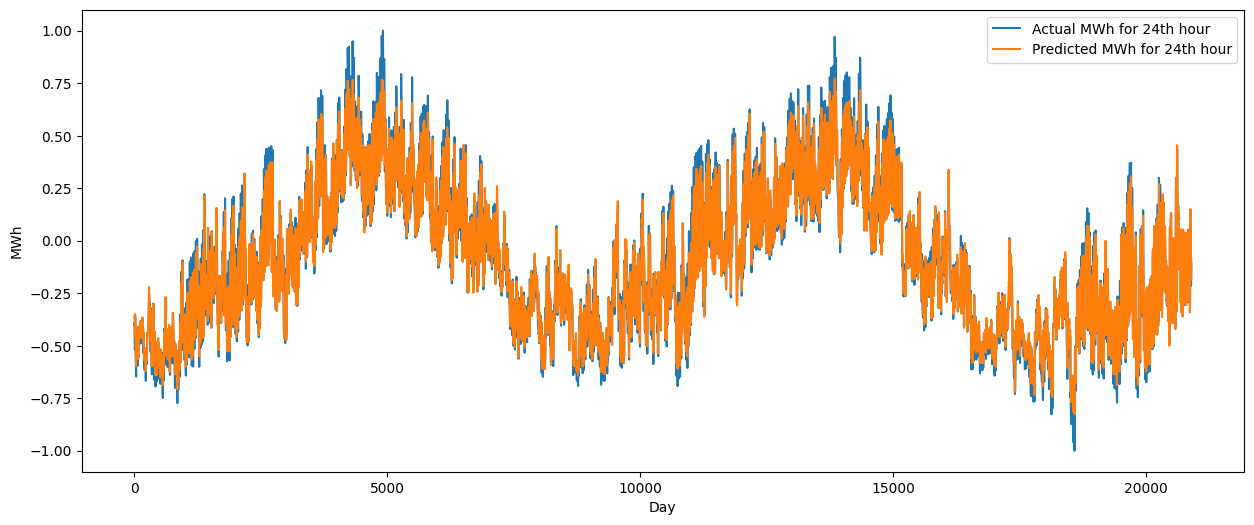

In [342]:
with torch.no_grad():
    predicted = model_new(X_train.to(device)).to("cpu").numpy()

predicted_24hr = predicted[:, -1]

plt.figure(figsize=(15, 6))
plt.plot(y_train[:, -1], label="Actual MWh for 24th hour");
plt.plot(predicted_24hr, label="Predicted MWh for 24th hour");
plt.xlabel("Day", );
plt.ylabel("MWh");
plt.legend();
plt.show();

In [337]:
from sklearn.preprocessing import MinMaxScaler

# Nehmen Sie an, dass Sie alle Spalten außer 'column_to_exclude1', 'column_to_exclude2' usw. skalieren möchten
columns_to_exclude = ['Rain', 'Wind', 'Sonne', "Day sin", "Day cos", "Year sin", "Year cos"]  # Fügen Sie hier die Spaltennamen ein, die Sie nicht skalieren möchten
columns_to_scale = [col for col in df.columns if col not in columns_to_exclude]

# Skalieren Sie nur die gewünschten Spalten
scaled_values = scaler.inverse_transform(df[columns_to_scale])

# Fügen Sie die skalierten Werte zurück in den DataFrame ein
df[columns_to_scale] = scaled_values

In [338]:
# Erstellen Sie einen Dummy-Array mit der gleichen Form wie Ihre ursprünglichen Daten
dummy_array = np.zeros((predicted.shape[0], 192))

# Legen Sie die Vorhersagen in die letzten 24 Spalten des Dummy-Arrays
dummy_array[:, -24:] = predicted

# Wenden Sie den Scaler auf das Dummy-Array an
destandardized_predictions = scaler.inverse_transform(dummy_array)

# Nehmen Sie nur die letzten 24 Spalten des resultierenden Arrays, das sind Ihre destandardisierten Vorhersagen
destandardized_predictions = destandardized_predictions[:, -24:]

,MWh,Temperatur,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH,Rain,Wind,Sonne,Day sin,Day cos,Year sin,Year cos
index,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,139.525004,4.1067,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.000000,1.000000,0.000000,1.000000
2019-01-01 01:00:00,129.716036,4.1067,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.258819,0.965926,0.000717,1.000000
2019-01-01 02:00:00,133.398074,3.7155,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.500000,0.866025,0.001434,0.999999
2019-01-01 03:00:00,135.133852,3.3243,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.707107,0.707107,0.002150,0.999998
2019-01-01 04:00:00,131.699424,2.9331,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,1,0,0.866025,0.500000,0.002867,0.999996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,171.707318,8.5300,1200.0,4000.0,1400.0,4069.0,1200.0,800.0,3200.0,1810.0,0,2,0,-0.965926,0.258819,0.001104,0.999999
2021-12-31 20:00:00,159.462903,8.0000,1200.0,4000.0,1400.0,4069.0,1200.0,800.0,3200.0,1810.0,0,2,0,-0.866025,0.500000,0.001821,0.999998
2021-12-31 21:00:00,155.109520,7.5000,1200.0,4000.0,1400.0,3953.0,1200.0,800.0,3200.0,1810.0,0,2,0,-0.707107,0.707107,0.002537,0.999997


In [ ]:
### Validation

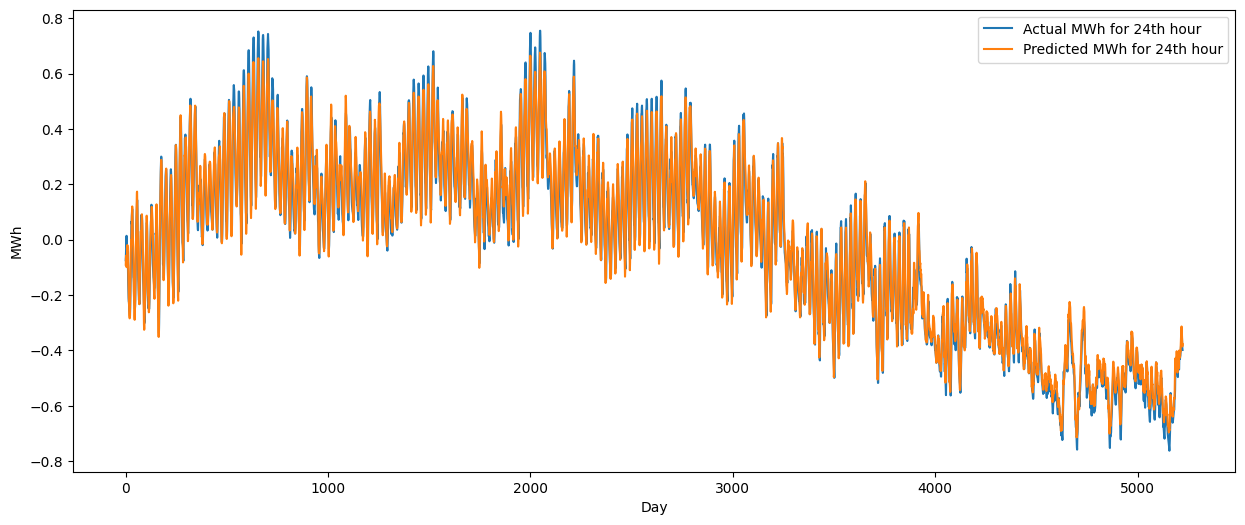

In [343]:
with torch.no_grad():
    predicted2 = model_new(X_val.to(device)).to("cpu").numpy()

predicted_24hr_2 = predicted2[:, -1]

plt.figure(figsize=(15, 6))
plt.plot(y_val[:, -1], label="Actual MWh for 24th hour");
plt.plot(predicted_24hr_2, label="Predicted MWh for 24th hour");
plt.xlabel("Day");
plt.ylabel("MWh");
plt.legend();
plt.show();